<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 4> Part 5: Prediction of Recovery Factor</font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

## Check PyCaret Version

In [1]:
from pycaret.utils import version
version()

'2.3.10'

#### Libraries

In [2]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes
#!pip install pycaret[full] --user
#!pip install mlflow --user
#!pip install tune-sklearn ray[tune] --user
#!pip install optuna -- user
#!pip install hyperopt --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

import ray
from ray import tune

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


In [3]:
# Function to read out file
def file_out(df, dir_name, base_filename, filename_suffix):
    try:
        csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
        df.to_csv(csvs_sht, index = False, header=True)
        print ("Final File Extract Produced")
    except IOError:
        print("I/O error")
    return

###### Declare some global variables

In [4]:
#Input Data
#dir_name = r'C:\Users\kswaminathan\OneDrive\01_KannaLibrary\15_Analogs'
#dir_name = r'C:\Users\mkumar\Documents\GitHub\SPE_Paper\Final'
dir_name = r'C:\Users\quant\Documents\GitHub\SPE_Paper\Final'
filename_suffix = 'csv'

##### Read in the data 

In [5]:
skiprows = 0
dfblind = pd.read_excel("BlindTest_SSOIL_NEW.xlsx", sheet_name='Inputs', thousands=',', skiprows = skiprows)
#dfblind = pd.read_excel("BlindTest_SSOIL.xlsx", thousands=',', skiprows = skiprows)
#dfblind = dfblind.loc[:, ~df.columns.str.contains('^Unnamed')] 
dfblind_ori = dfblind.copy()
#dfblind.drop('307_Recovery factor (ultimate oil) (%)', axis=1, inplace=True)
#dfblind.dropna(axis = 0, inplace=True)

dfblind.head(10)

,10_Region,11_Basin name,52_Well spacing (average) (ac),72_Onshore or offshore,75_Temperature (original) (deg. F),77_Pressure (original) (psi),82_Drive mechanism (main),117_Reservoir top subsea depth (ft TVDSS),118_Structural flank dip (average) (deg.),149_Reservoir period,...,161_Reservoir architecture (main),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),307_Recovery factor (ultimate oil) (%),EORIOR
0,FORMER SOVIET UNION,SIBERIAN WESTERN,119.000000,ONSHORE,138.00,3756,GAS DRIVE,8544.4,1,CRETACEOUS,...,LABYRINTH,0.590000,18.00,100.000000,40.0,1.00,580,490.00,0,4
1,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,214.157667,OFFSHORE,200.66,4670,GAS DRIVE,2900.0,2,JURASSIC,...,LAYER-CAKE,0.520619,19.00,47.000000,33.0,0.60,775,116.00,0,5
2,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,122.316975,OFFSHORE,199.94,4683,GAS DRIVE,2900.0,5,JURASSIC,...,LAYER-CAKE,0.520619,23.00,76.000000,29.0,0.80,707,129.00,0,5
3,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,563.399400,OFFSHORE,200.48,4534,GAS DRIVE,2900.0,5,JURASSIC,...,LAYER-CAKE,0.379808,20.00,151.000000,34.0,0.30,1661,98.00,0,0
4,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,441.082425,OFFSHORE,205.52,6258,GAS DRIVE,3310.7,8,NEOGENE,...,LAYER-CAKE,0.760870,23.00,55.000000,30.0,0.86,683,47.00,0,1
5,ASIA-PACIFIC,SARAWAK,54.783857,OFFSHORE,202.30,4262,AQUIFER DRIVE,4322.8,2,NEOGENE,...,LAYER-CAKE,0.695000,35.40,47.430535,30.0,0.39,2500,10.70,0,3
6,ASIA-PACIFIC,SARAWAK,98.943076,OFFSHORE,202.30,4575,AQUIFER DRIVE,3023.2,1,NEOGENE,...,LAYER-CAKE,0.627000,41.08,55.040858,36.0,0.30,1500,16.53,0,3
7,AFRICA,ABU GHARADIG,140.000000,ONSHORE,232.00,4500,GAS DRIVE,9350.0,5,CRETACEOUS,...,JIGSAW-PUZZLE,0.100000,21.00,140.000000,40.5,13.81,850,166.00,0,2


## Load the Model

In [6]:
from pycaret.regression import load_model
from pycaret.regression import predict_model

from functools import reduce

final_blend = load_model('Blended_model_21042022')
final_db = load_model('Boosted_CatBoost_21042022')
final_gbr = load_model('Boosted_GBR_21042022')
final_rf = load_model('Boosted_RF_21042022')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [7]:
print(final_blend)

Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(ml_usecase='regression',
                                      target='307_Recovery factor (ultimate '
                                             'oil) (%)')),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catagorical_Levels_in_TestData(replacement_strat...
                 VotingRegressor(estimators=[('catboost',
                                              <catboost.core.CatBoostRegressor object at 0x0000029DB4A6A348>),
                                             ('gbr',
                                              GradientBoostingRegressor(learning_rate=0.05,
                       

In [8]:
BlindPredict1 = predict_model(final_blend, data=dfblind, round=2)
BlindPredict2 = predict_model(final_db, data=dfblind, round=2)
BlindPredict3 = predict_model(final_gbr, data=dfblind, round=2)
BlindPredict4 = predict_model(final_rf, data=dfblind, round=2)

BlindPredict1 = BlindPredict1.rename(columns={'Label': 'Blended Predicted Recovery factor (ultimate oil) (%)'
                                 })
BlindPredict2 = BlindPredict2.rename(columns={'Label': 'CatBoost Predicted Recovery factor (ultimate oil) (%)'
                                 })
BlindPredict3 = BlindPredict3.rename(columns={'Label': 'Gradient Boost Predicted Recovery factor (ultimate oil) (%)'
                                 })
BlindPredict4 = BlindPredict4.rename(columns={'Label': 'Random Forest Predicted Recovery factor (ultimate oil) (%)'
                                 })

BlindPredict_df = [BlindPredict1, BlindPredict2, BlindPredict3, BlindPredict4]

BlindPredict = pd.concat(BlindPredict_df, axis = 0, join = 'outer').drop_duplicates()
BlindPredict = BlindPredict.reset_index(drop=True)

BlindPredict

,10_Region,11_Basin name,52_Well spacing (average) (ac),72_Onshore or offshore,75_Temperature (original) (deg. F),77_Pressure (original) (psi),82_Drive mechanism (main),117_Reservoir top subsea depth (ft TVDSS),118_Structural flank dip (average) (deg.),149_Reservoir period,153_Depositional system (main),161_Reservoir architecture (main),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),307_Recovery factor (ultimate oil) (%),EORIOR,Blended Predicted Recovery factor (ultimate oil) (%),CatBoost Predicted Recovery factor (ultimate oil) (%),Gradient Boost Predicted Recovery factor (ultimate oil) (%),Random Forest Predicted Recovery factor (ultimate oil) (%)
0,FORMER SOVIET UNION,SIBERIAN WESTERN,119.000000,ONSHORE,138.00,3756,GAS DRIVE,8544.4,1,CRETACEOUS,24:COASTAL,LABYRINTH,0.590000,18.00,100.000000,40.0,1.00,580,490.00,0,4,40.855644,NaN,NaN,NaN
1,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,214.157667,OFFSHORE,200.66,4670,GAS DRIVE,2900.0,2,JURASSIC,21:FLUVIAL,LAYER-CAKE,0.520619,19.00,47.000000,33.0,0.60,775,116.00,0,5,41.378587,NaN,NaN,NaN
2,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,122.316975,OFFSHORE,199.94,4683,GAS DRIVE,2900.0,5,JURASSIC,21:FLUVIAL,LAYER-CAKE,0.520619,23.00,76.000000,29.0,0.80,707,129.00,0,5,44.387729,NaN,NaN,NaN
3,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,563.399400,OFFSHORE,200.48,4534,GAS DRIVE,2900.0,5,JURASSIC,21:FLUVIAL,LAYER-CAKE,0.379808,20.00,151.000000,34.0,0.30,1661,98.00,0,0,39.150040,NaN,NaN,NaN
4,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,441.082425,OFFSHORE,205.52,6258,GAS DRIVE,3310.7,8,NEOGENE,21:FLUVIAL,LAYER-CAKE,0.760870,23.00,55.000000,30.0,0.86,683,47.00,0,1,41.408185,NaN,NaN,NaN
5,ASIA-PACIFIC,SARAWAK,54.783857,OFFSHORE,202.30,4262,AQUIFER DRIVE,4322.8,2,NEOGENE,24:COASTAL,LAYER-CAKE,0.695000,35.40,47.430535,30.0,0.39,2500,10.70,0,3,41.132795,NaN,NaN,NaN
6,ASIA-PACIFIC,SARAWAK,98.943076,OFFSHORE,202.30,4575,AQUIFER DRIVE,3023.2,1,NEOGENE,24:COASTAL,LAYER-CAKE,0.627000,41.08,55.040858,36.0,0.30,1500,16.53,0,3,39.522360,NaN,NaN,NaN
7,AFRICA,ABU GHARADIG,140.000000,ONSHORE,232.00,4500,GAS DRIVE,9350.0,5,CRETACEOUS,24:COASTAL,JIGSAW-PUZZLE,0.100000,21.00,140.000000,40.5,13.81,850,166.00,0,2,17.857463,NaN,NaN,NaN
8,FORMER SOVIET UNION,SIBERIAN WESTERN,119.000000,ONSHORE,138.00,3756,GAS DRIVE,8544.4,1,CRETACEOUS,24:COASTAL,LABYRINTH,0.590000,18.00,100.000000,40.0,1.00,580,490.00,0,4,NaN,39.321692,NaN,NaN
9,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,214.157667,OFFSHORE,200.66,4670,GAS DRIVE,2900.0,2,JURASSIC,21:FLUVIAL,LAYER-CAKE,0.520619,19.00,47.000000,33.0,0.60,775,116.00,0,5,NaN,40.392197,NaN,NaN


In [9]:
aggregation_functions = {
    'Blended Predicted Recovery factor (ultimate oil) (%)': 'sum', 
    'CatBoost Predicted Recovery factor (ultimate oil) (%)': 'sum',
    'Gradient Boost Predicted Recovery factor (ultimate oil) (%)': 'sum',
    'Random Forest Predicted Recovery factor (ultimate oil) (%)': 'sum',
}

labels = dfblind.columns.tolist()

BlindPredict_new = BlindPredict.groupby(labels).aggregate(aggregation_functions)

file_out(BlindPredict, dir_name, 'Blind_Test_Out' , filename_suffix)

BlindPredict_new

Final File Extract Produced


Blended Predicted Recovery factor (ultimate oil) (%)  \
10_Region           11_Basin name                    52_Well spacing (average) (ac) 72_Onshore or offshore 75_Temperature (original) (deg. F) 77_Pressure (original) (psi) 82_Drive mechanism (main) 117_Reservoir top subsea depth (ft TVDSS) 118_Structural flank dip (average) (deg.) 149_Reservoir period 153_Depositional system (main) 161_Reservoir architecture (main) 176_Net/gross ratio (average) 204_Porosity (matrix average) (%) 210_Permeability (air average) (mD) 218_API gravity (average) (deg. API) 225_Viscosity (oil average) (cp) 252_GOR (initial average) (SCF/STB) 293_Original in-place oil equivalent (MMBOE) 307_Recovery factor (ultimate oil) (%) EORIOR                                                         
AFRICA              ABU GHARADIG                     140.000000                     ONSHORE                232.00                             4500                         GAS DRIVE                 9350.0                                    5                                         CRETACEOUS           24:COASTAL                     JIGSAW-PUZZLE                     0.100000                      21.00                             140.000000                          40.5                                 13.81                            850                                 166.00                                       0                                      2                                               17.857463      
ASIA-PACIFIC        SARAWAK                          54.783857                      OFFSHORE               202.30                             4262                         AQUIFER DRIVE             4322.8                                    2                                         NEOGENE              24:COASTAL                     LAYER-CAKE                        0.695000                      35.40                             47.430535                           30.0                                 0.39                             2500                                10.70                                        0                                      3                                               41.132795      
                                                     98.943076                      OFFSHORE               202.30                             4575                         AQUIFER DRIVE             3023.2                                    1                                         NEOGENE              24:COASTAL                     LAYER-CAKE                        0.627000                      41.08                             55.040858                           36.0                                 0.30                             1500                                16.53                                        0                                      3                                               39.522360      
FORMER SOVIET UNION SIBERIAN WESTERN                 119.000000                     ONSHORE                138.00                             3756                         GAS DRIVE                 8544.4                                    1                                         CRETACEOUS           24:COASTAL                     LABYRINTH                         0.590000                      18.00                             100.000000                          40.0                                 1.00                             580                                 490.00                                       0                                      4                                               40.855644      
LATIN AMERICA       GULF OF MEXICO NORTHERN OFFSHORE 122.316975                     OFFSHORE               199.94                             4683                         GAS DRIVE                 2900.0                                    5                                         JURASSIC             21:FLUVIAL                     LAYER-

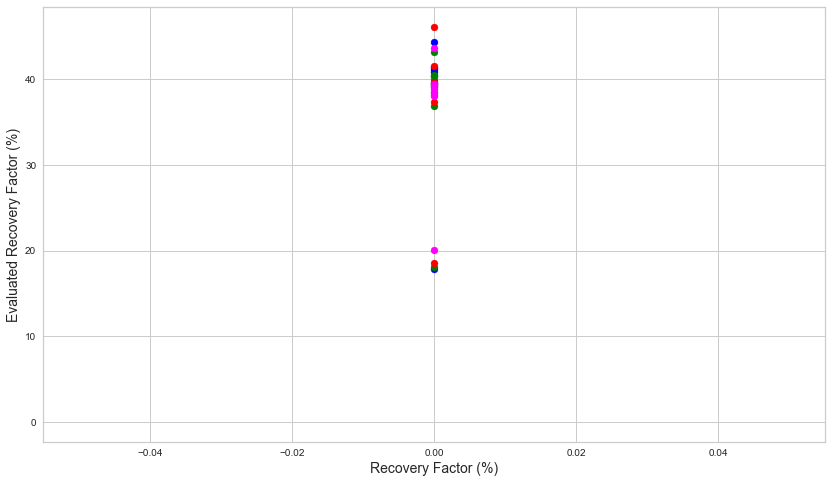

In [10]:
a = BlindPredict['307_Recovery factor (ultimate oil) (%)']
b = BlindPredict['Blended Predicted Recovery factor (ultimate oil) (%)']
c = BlindPredict['CatBoost Predicted Recovery factor (ultimate oil) (%)']
d = BlindPredict['Gradient Boost Predicted Recovery factor (ultimate oil) (%)']
e = BlindPredict['Random Forest Predicted Recovery factor (ultimate oil) (%)']

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.scatter(a, c, color='green')
plt.scatter(a, d, color='red')
plt.scatter(a, e, color='magenta')
plt.plot(a, a, color = 'black', ls = '--', label = 'x=y')
plt.xlabel("Recovery Factor (%)", size=14)
plt.ylabel("Evaluated Recovery Factor (%)", size=14)

#plt.tight_layout()
plt.show()